# __Classical forecasting methods__

## Forecasting with the Holt-Winters Method
The Holt-Winters method takes the trend as well as seasonality into account

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [5]:
#set desired DateTimeIndex as index and parse dates leads to DateTimeIndex right away
df = pd.read_csv('../data/airline_passengers.csv', index_col=0, parse_dates=True)
#To make the DateTimeIndex up of time points at the beginning of each month
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
print(df.index.min())
print(df.index.max())

1949-01-01 00:00:00
1960-12-01 00:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [56]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


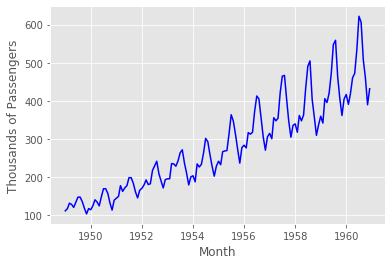

In [12]:
plt.style.use('ggplot')

fig = sns.lineplot(x=df.index, y=df['Thousands of Passengers'], color='blue')

### __Train test split__

In [13]:
train_data = df.iloc[:109]
test_data = df.iloc[108:]

### __Fitting model to Holt-Winters model__

#### __Additive model__

An additive model is linear where changes over time are consistently made by the same amount. <br/>
A linear trend is a straight line.<br/>
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

#### __Multiplicative model__

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.<br/>
A nonlinear trend is a curved line.<br/>
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],
                                    trend='mul',seasonal='mul',
                                    seasonal_periods=12).fit()

#the trend is multiplicative as it shows exponential growth
#the seasonality is multiplicative as it shows constant grwoth 

### __Make predicions with fitted model__

In [40]:
#forecast of 36 periods (hence 36 months) into future
predictions = fitted_model.forecast(36).rename('HW Forecast')

In [41]:
predictions.head()

1958-02-01    339.139712
1958-03-01    399.277032
1958-04-01    394.227755
1958-05-01    402.541455
1958-06-01    473.130959
Freq: MS, Name: HW Forecast, dtype: float64

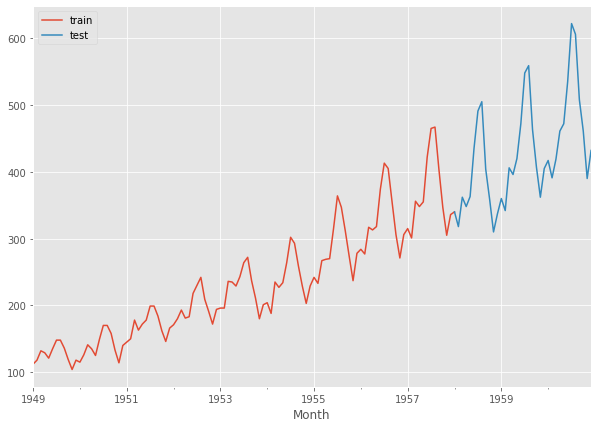

In [42]:
train_data['Thousands of Passengers'].plot(legend=True,label='train')
test_data['Thousands of Passengers'].plot(legend=True,label='test',figsize=(10,7));

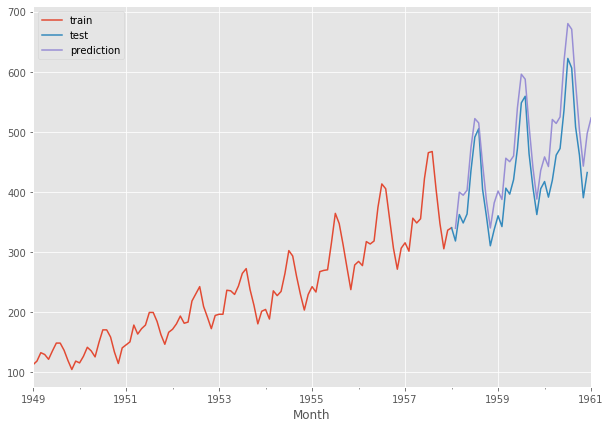

In [43]:
train_data['Thousands of Passengers'].plot(legend=True,label='train')
test_data['Thousands of Passengers'].plot(legend=True,label='test',figsize=(10,7))
test_predictions.plot(legend=True,label='prediction');

### __Model evaluation__

In [47]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [51]:
MAE = mean_absolute_error(test_data,test_predictions)
MAE

63.03016344745991

In [53]:
relative_MAE = MAE/df.mean()
relative_MAE

Thousands of Passengers    0.224868
dtype: float64

### __Root mean square error (RMSE)__

$RMSE = \sqrt{\frac{\sum\limits_{t=1}^n(F_t - A_t)^2}{n}}$ <br/>
<br/>
$F_t$: forecast value <br/>
$A_t$: actual value <br/>
$n$: sample size

In [54]:
np.sqrt(mean_squared_error(test_data,test_predictions))

74.92727460739599

### __Stationarity__

Stationary data do not feature any trend nor seasonality. Any fluctuations are noise.

In [58]:
df2 = pd.read_csv('../data/samples.csv',index_col=0,parse_dates=True)
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


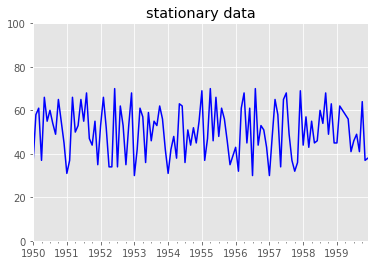

In [60]:
plt.style.use('ggplot')
df2['a'].plot(ylim=[0,100],title="stationary data", color='blue').autoscale(axis='x',tight=True);

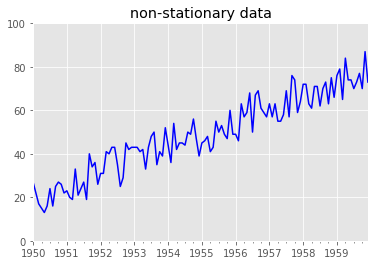

In [61]:
plt.style.use('ggplot')
df2['b'].plot(ylim=[0,100],title='non-stationary data', color='blue').autoscale(axis='x',tight=True);

### __Differencing__
Stationarity of non-stationary data can be accomplished through differencing. Differencing calculates the difference between consecutive points.

#### __Using statsmodels__

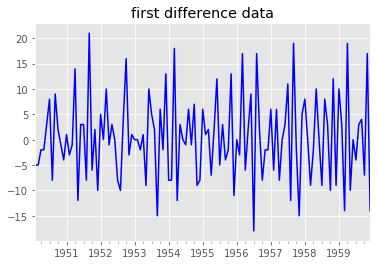

In [65]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['b'],k_diff=1)

df2['d1'].plot(title="first difference data", color='blue').autoscale(axis='x',tight=True);

#### __Using pandas__

In [64]:
df2['d1'] = df2['b'] - df2['b'].shift(1)
df2.head()

,a,b,c,d,d1
1950-01-01,36,27,0,67,NaN
1950-02-01,58,22,3,31,-5.0
1950-03-01,61,17,5,67,-5.0
1950-04-01,37,15,8,47,-2.0
1950-05-01,66,13,8,62,-2.0


# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Great, let's get started!